In [3]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
df = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.dropna(subset=["PRC"])

In [52]:
window_length    = 100
start_index      = 50
forecast_horizon = 5
smoothing_window = 5
alpha_scale      = 0.5
beta             = 0.1


tau              = 1.0   # example parameter
w                = 0.5   # example parameter
penalty          = 10.0  # example penalty factor
Q_target         = 100.0
Q0               = 100.0
J0               = 0.0

gamma0           = 0.0
gammaT           = 0.1
gamma = np.linspace(gamma0, gammaT, window_length+1)
lambda_vals = np.exp(gamma)  # lambda_t = exp(gamma_t)
delta_gamma = np.diff(gamma)

In [53]:
df_window = df.iloc[start_index:start_index + window_length + 1].copy()
T = window_length
prices = df_window["PRC"].values  # length T+1

# --- Construct synthetic alpha signal ---
df_window["raw_alpha"] = (df_window["PRC"].shift(-forecast_horizon) / df_window["PRC"] - 1)
df_window["alpha"] = df_window["raw_alpha"].rolling(smoothing_window, min_periods=1).mean()
df_window["alpha"].fillna(method="ffill", inplace=True)

df_window["alpha"] *= alpha_scale
t = np.arange(len(df_window))
df_window["alpha"] *= np.exp(-beta * t)

# Extract the alpha signal for t=0,...,T
alpha_base = df_window["alpha"].values[:T+1]

In [54]:
def run_optimization_trial(alpha_base, gamma, tau, w_param, penalty, Q_target, Q0, J0, sigma_alpha, T, lambda_vals, delta_gamma):
    # Add Gaussian noise to the alpha signal
    alpha_noisy = alpha_base + np.random.normal(0, sigma_alpha, size=len(alpha_base))
    delta_alpha_noisy = np.diff(alpha_noisy)
    
    # Set up CVXPY problem for this trial.
    J = cp.Variable(T+1)
    obj_terms = []
    for t in range(T):
        term = (np.exp(-gamma[t]) *
                ( J[t] * delta_alpha_noisy[t]
                  + (1/tau + delta_gamma[t]) * alpha_noisy[t] * J[t]
                  - (w_param/tau) * cp.square(J[t])
                  - delta_gamma[t] * 0.5 * w_param * cp.square(J[t])
                )
               )
        obj_terms.append(term)
    terminal_term = np.exp(-gamma[T]) * (alpha_noisy[T]*J[T] - 0.5*w_param*cp.square(J[T]))
    obj_terms.append(terminal_term)
    
    # Portfolio position from trades
    position_increments = []
    for t in range(T):
        position_increments.append((J[t+1] - (1 - 1/tau)*J[t]) / lambda_vals[t])
    Q_T_expr = Q0 + cp.sum(cp.hstack(position_increments))
    deviation_expr = Q_target - Q_T_expr
    penalty_term = - penalty * cp.square(deviation_expr)
    
    objective = cp.Maximize(cp.sum(cp.hstack(obj_terms)) + penalty_term)
    constraints = [J[0] == J0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    
    if J.value is None:
        return None, None
    J_opt_trial = J.value
    Q_history_trial = [Q0]
    for t in range(T):
        delta_Q = (J_opt_trial[t+1] - (1 - 1/tau)*J_opt_trial[t]) / lambda_vals[t]
        Q_history_trial.append(Q_history_trial[-1] + delta_Q)
    Q_history_trial = np.array(Q_history_trial)
    return Q_history_trial, J_opt_trial

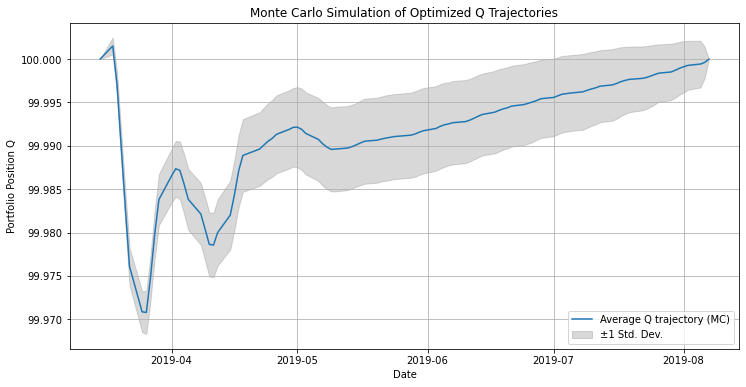

In [55]:
# Set Monte Carlo parameters:
num_trials = 1000
sigma_alpha = 0.001  # noise level for alpha
results = []
for trial in range(num_trials):
    np.random.seed(trial)
    Q_hist_trial, J_trial = run_optimization_trial(alpha_base, gamma, tau, w, penalty, Q_target, Q0, J0, sigma_alpha, T, lambda_vals, delta_gamma)
    if Q_hist_trial is not None:
        results.append(Q_hist_trial)

results = np.array(results)
average_Q = np.mean(results, axis=0)
std_Q = np.std(results, axis=0)

dates = df_window["date"].values[:T+1]


# Plot the average Q trajectory and a band for ± one standard deviation.
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(dates, average_Q, label="Average Q trajectory (MC)")
plt.fill_between(dates, average_Q - std_Q, average_Q + std_Q, color='gray', alpha=0.3, label="±1 Std. Dev.")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q")
plt.title("Monte Carlo Simulation of Optimized Q Trajectories")
plt.legend()
plt.grid(True)
plt.show()